In [2]:
#Read in PMID csv file created through
path = "/Users/manatee_prime/Documents/covid/"

pmids = []

f = open(path + '20200315_pubmed_result.txt','r')
for line in f:
    pmids.append(line.rstrip())

print(len(pmids),pmids[0:10])

1031 ['32171076', '32171075', '32171074', '32171067', '32171063', '32171062', '32171059', '32171057', '32171055', '32171054']


In [120]:
#This code returns grant information on all pmids gathered from pubmed
#It is modified slightly to retrieve additional info (article name, author affiliation)
import collections
import requests
import urllib.request
from bs4 import BeautifulSoup
import time

#NOTE: consider adding article date information to grant scraper for accurate dating down to the day
#      use 'pubdate' to grab date information for future grant searches

fgrant = [[],[],[]] #0 = grant num, 1 = grant agency, 2 = grant country
author = [[],[]] #0 = author name, 1 = affiliation
article = [[],[],[],[]] #0 = pub date, 1 = journal, 2 = title, 3 = article type (letter, research art, rev, etc.)
ct = 0

for x in pmids:
    
    #Counter to track number of citations tackled
    ct += 1
    if ct % 300 == 0:
        print(ct/len(pmids),' completed!')
    
    skey = 'dcff69acdc62008c90b1354b0ac141dc0808' #api key to get more queries to ncbi eutils
    time.sleep(0.2) #setting to 0.1 throws over-query error
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={0}&retmode=xml&api_key={1}".format(x,skey)
    response = requests.get(url)
    soup = BeautifulSoup(response.text,'html.parser')
        
    ###SCRAPE PUBLICATION ARTICLE INFORMATION###
    #Date
    date = soup.find_all('pubdate')
    pubdate = ''
    for item in date:
        for subitem in item: #pubdate lists in order: year, month, day
            if 'year' in str(subitem):
                pubdate = str(subitem).split('>')[1].split('<')[0]
            if 'month' in str(subitem):
                pubdate = pubdate + '-' + str(subitem).split('>')[1].split('<')[0]
            if 'day' in str(subitem):
                pubdate = pubdate + '-' + str(subitem).split('>')[1].split('<')[0]
        if pubdate.count('-') == 1:
            pubdate = pubdate + '-01' #arbitrarily set Y-M dates to Y-M-01 (start of month)
    article[0].append(pubdate)
    
    #Journal name
    for jrn in soup.find_all('isoabbreviation'):
        article[1].append(str(jrn).split('>')[1].split('<')[0])
    #Article name/type
    article[2].append(str(soup.find_all('articletitle')).split('>')[1].split('<')[0])
    article[3].append(str(soup.find_all('publicationtype')).split('>')[1].split('<')[0])
    ###END ARTICLE BLOCK###
    
    ####SCRAPE AUTHOR INFORMATION###
    athr = soup.find_all('author')
    for n in athr:
        tmpa = [[],[]]
        for subn in n:
            if '<lastname>' in str(subn):
                tmpa[0].append(str(subn).split('>')[1].split('<')[0])
            if '<forename>' in str(subn):
                tmpa[0][-1] = tmpa[0][-1] + ' ' + str(subn).split('>')[1].split('<')[0]
            if '<affiliation>' in str(subn):
                tmpa[1].append(str(subn).split('<affiliation>')[1].split('</affiliation>')[0])
        if len(tmpa[1]) == 0:
            tmpa[1] = ['NA']
    author[0].append(tmpa[0])
    author[1].append(tmpa[1])
    ###END AUTHOR BLOCK ###
    
    ###SCRAPE GRANT INFORMATION###
    content = soup.find_all('grant')
    if len(content) == 0:
        fgrant[0].append('NA')
        fgrant[1].append('NA')
        fgrant[2].append('NA')
        continue

    for item in content:
        grant = [[],[],[]]
        gid = False
        agency = False
        country = False
            
        for j in item:
            if 'grantid' in str(j):
                grant[0].append(str(j).split('>')[1].split('<')[0])
                gid = True
                continue
            if 'agency' in str(j):
                grant[1].append(str(j).split('>')[1].split('<')[0])
                agency = True
                continue
            if 'country' in str(j):
                grant[2].append(str(j).split('>')[1].split('<')[0])
                country = True
                continue
            
        if gid == False:
            grant[0].append('NA')
        if agency == False:
            grant[1].append('NA')
        if country == False:
            grant[2].append('NA')
    fgrant[0].append(grant[0])
    fgrant[1].append(grant[1])
    fgrant[2].append(grant[2])
        ###END GRANT BLOCK###
    
print(len(article[0]),len(article[1]),
      len(author[0]),len(author[1]),
     len(fgrant[0]),len(fgrant[1]),len(fgrant[2]))

0.2909796314258002  completed!
0.5819592628516004  completed!
0.8729388942774006  completed!
1031 1030 1031 1031 1031 1031 1031


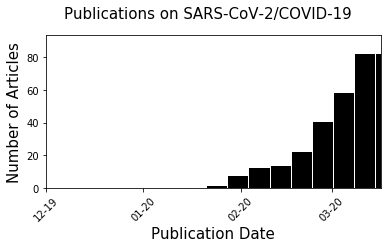

In [279]:
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

pubtype = ['Journal Article','Case Reports','Guideline','Letter'] #limit plot to publications
chklst = ['USA','U.S.A.', 'United States', 'California', ' CA ', 'Massachusetts', ' MA ', 'Maryland', ' MD ',
      'FL', 'Florida', 'GA', 'Georgia', 'NY', 'New York', 'Washington', ' WA '] #find US publications

'''
for i in range(len(article[0])):
    if article[0][i].count('-') == 2: #only use articles with decent dates
        try:
            print(article[0][i])
            int(article[0][i].split('-')[1]) #test if month is %m
            article[0][i] = datetime.strptime(article[0][i], '%Y-%m-%d')
        except ValueError:
            article[0][i] = datetime.strptime(article[0][i], '%Y-%b-%d')
'''
dat = [[],[],[]] #0 = all pubs, 1 = pubs w/ 1+ authors w/ USA affiliation, 2 = chinese pubs
for x in range(len(article[0])):
    #Get all published articles
    if isinstance(article[0][x],datetime) == True and article[3][x] in pubtype:
        #Get only USA affiliated published articles
        for subitem in author[1][x]:
            a = False
            b = False
            if subitem != 'NA':
                for chk in chklst: #see if a chklst word appears in subitem
                    if chk in subitem:
                        a = True #flag that a chklst word has appeared
                        dat[1].append(article[0][x]) #append article date to dat[1] for plotting
                        break #exit as we count anything with 1+ author from US as a US publication
                    if 'China' in subitem:
                        b = True
                        dat[2].append(article[0][x])
                        break
                if a != False or b != False:
                    break
        #Put rest of publications into another bin
        if a == False:
            dat[0].append(article[0][x])
                    
# convert the epoch format to matplotlib date format 
mpl_dat0 = mdates.date2num(dat[0])
mpl_dat1 = mdates.date2num(dat[1])
mpl_dat2 = mdates.date2num(dat[2])

# plot it
fig, ax = plt.subplots(1,1)
#ax.hist([mpl_dat0,mpl_dat2,mpl_dat1], bins=50, color=['k','r','b'],edgecolor='w',stacked=True,cumulative=False)
#ax.legend(['Rest of World','China','USA'])
ax.hist(mpl_dat1,bins=50,color='k',edgecolor='w',cumulative=True)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
ax.set_xlim([datetime.strptime("12/01/2019", "%m/%d/%Y"), datetime.now()])
plt.xticks(rotation=45)
fig.suptitle('Publications on SARS-CoV-2/COVID-19', fontsize=15)
plt.xlabel('Publication Date', fontsize=15)
plt.ylabel('Number of Articles', fontsize=15)
plt.gcf().subplots_adjust(bottom=0.35)
plt.savefig(path + '20200316_pubct_cum_usa.png',dpi=200,transparent=True)
plt.show()

In [138]:
###CHECK IF ANY PUBS HAVE MULTIPLE FUNDING SOURCES###
for item in fgrant[1]:
    if item != 'NA':
        if len(item) > 1:
            print(len(item))

In [204]:
###THIS SECTION COULD HAVE GRANT NETWORK INFO EVENTUALlY###

In [237]:
###CHECK FOR ASSORTMENT OF AFFILIATIONS###


dat = [[],[]]
for i in range(len(author[1])):
    

print(len(dat[1]))

104
